# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum


from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify_Churn_Prediction").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load

In [3]:
path = "mini_sparkify_event_data.json"
data_full = spark.read.json(path)

### Check Structure

In [74]:
data_full.count()

286500

In [76]:
data_full.select("userId").dropDuplicates().count()

226

### Check Null Values

In [77]:
data_cleaned = data_full.dropna(how = "any", subset = ["userId", "sessionId"])
data_cleaned.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [78]:
data_cleaned.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [79]:
data_cleaned = data_cleaned.filter(data_cleaned["userId"] != "")
data_cleaned.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [80]:
churn = udf(lambda x : 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
downgrade = udf(lambda x : 1 if x == 'Downgrade' else 0, IntegerType())

In [81]:
data_cleaned_churn = data_cleaned.withColumn('Churn',churn('page'))
data_cleaned_full  = data_cleaned_churn.withColumn('Downgrade',downgrade('page'))

In [82]:
data_cleaned_full.groupby(["Churn"]).count().toPandas()

,Churn,count
0,1,52
1,0,278102


### Amount

In [15]:
data_cleaned_full.dropDuplicates(["userId"]).count()

225

In [16]:
data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()

52

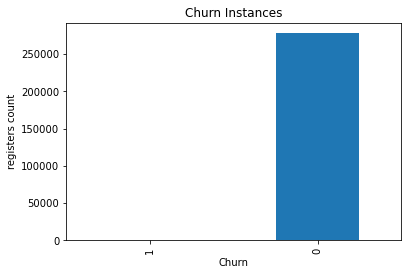

In [14]:
data_cleaned_full.groupby(["Churn"]).count().toPandas().set_index('Churn').plot(kind='bar', legend = False);
plt.title('Churn Instances')
plt.ylabel('registers count');

In [15]:
data_cleaned_full.filter(data_cleaned_full.Downgrade == 1).dropDuplicates(["userId"]).count()

154

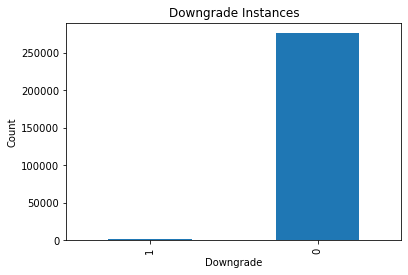

In [16]:
data_cleaned_full.groupby(['Downgrade']).count().toPandas().set_index('Downgrade').plot(kind='bar', legend = False);
plt.title('Downgrade Instances')
plt.ylabel('Count');

### City

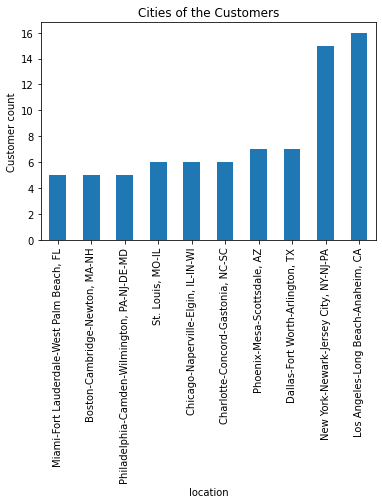

In [17]:
plot_2 = data_cleaned_full.dropDuplicates(['userId']).groupby(['location']).count().sort('count').toPandas().tail(10)
plot_2.set_index('location').plot(kind='bar', legend = False);
plt.title('Cities of the Customers')
plt.ylabel('Customer count');

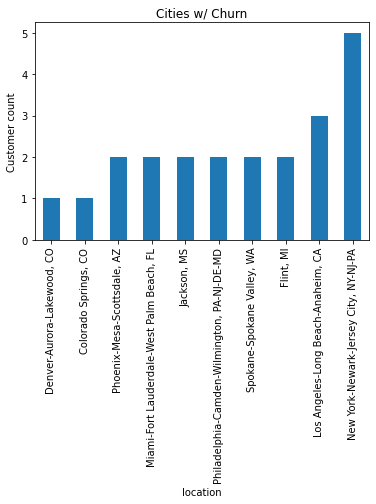

In [18]:
plot_3 = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(['userId']).groupby(['location']).count().sort('count').toPandas().tail(10)
plot_3.set_index('location').plot(kind='bar', legend = False);
plt.title('Cities w/ Churn')
plt.ylabel('Customer count');

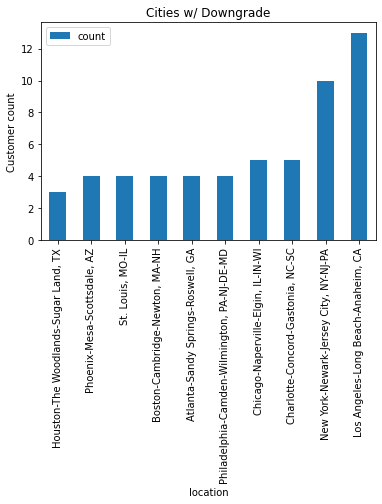

In [19]:
plot_4 = data_cleaned_full.filter(data_cleaned_full.Downgrade == 1).dropDuplicates(['userId']).groupby(['location']).count().sort('count').toPandas().tail(10)
plot_4.set_index('location').plot(kind='bar');
plt.title('Cities w/ Downgrade')
plt.ylabel('Customer count');

### Gender

In [20]:
data_cleaned_full.dropDuplicates(["userId"]).groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [21]:
data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+



In [22]:
data_cleaned_full.filter(data_cleaned_full.Downgrade == 1).dropDuplicates(["userId"]).groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|   75|
|     M|   79|
+------+-----+



### Page

In [23]:
page = data_cleaned_full.groupby(['page']).count().sort('count').toPandas().set_index('page')

<AxesSubplot:xlabel='page'>

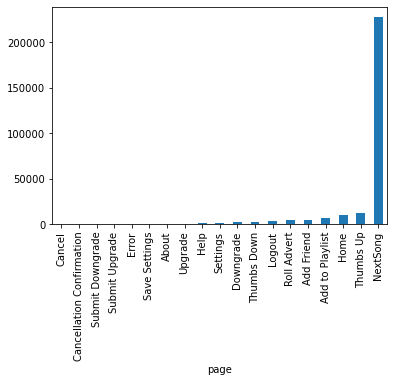

In [24]:
page.plot(kind = 'bar', legend = False)

### Possible Causes

#### - Churn

In [25]:
churn_customers = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(['userId']).select('userId')

In [26]:
churn_ids = [int(row.userId) for row in churn_customers.collect()]

#### - Bad Recommendations

In [27]:
td_churn = data_cleaned_full.filter((data_cleaned_full.page == 'Thumbs Down')&(data_cleaned_full.userId.isin(churn_ids))).count()

n_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()
n_total = data_cleaned_full.dropDuplicates(["userId"]).count()
n_not_churn = n_total - n_churn

print('The amount of thumbsdown for churn customers is {}. The mean amount of thumbs down per customer is {}.'.format(td_churn, td_churn/n_churn))

The amount of thumbsdown for churn customers is 496. The mean amount of thumbs down per customer is 9.538461538461538.


In [28]:
td_not_churn = data_cleaned_full.filter((data_cleaned_full.page == 'Thumbs Down')&(data_cleaned_full.userId.isin(churn_ids)==False)).count()

n_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()
n_total = data_cleaned_full.dropDuplicates(["userId"]).count()
n_not_churn = n_total - n_churn

print('The amount of thumbsdown for not churn customers is {}. The mean amount of thumbs down per customer is {}.'.format(td_not_churn, td_not_churn/n_not_churn))

The amount of thumbsdown for not churn customers is 2050. The mean amount of thumbs down per customer is 11.84971098265896.


#### - Not enough connections

In [29]:
fa_churn = data_cleaned_full.filter((data_cleaned_full.page == 'Add Friend')&(data_cleaned_full.userId.isin(churn_ids))).count()

n_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()
n_total = data_cleaned_full.dropDuplicates(["userId"]).count()
n_not_churn = n_total - n_churn

print('The amount of friend adds for churn customers is {}. The mean amount of friend adds per customer is {}.'.format(fa_churn, fa_churn/n_churn))

The amount of friend adds for churn customers is 636. The mean amount of friend adds per customer is 12.23076923076923.


In [30]:
fa_not_churn = data_cleaned_full.filter((data_cleaned_full.page == 'Add Friend')&(data_cleaned_full.userId.isin(churn_ids)==False)).count()

n_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()
n_total = data_cleaned_full.dropDuplicates(["userId"]).count()
n_not_churn = n_total - n_churn

print('The amount of friend adds for not churn customers is {}. The mean amount of friend adds per customer is {}.'.format(fa_not_churn, fa_not_churn/n_not_churn))

The amount of friend adds for not churn customers is 3641. The mean amount of friend adds per customer is 21.046242774566473.


#### Not Understand how the app works

In [31]:
help_churn = data_cleaned_full.filter((data_cleaned_full.page == 'Help')&(data_cleaned_full.userId.isin(churn_ids))).count()

n_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()
n_total = data_cleaned_full.dropDuplicates(["userId"]).count()
n_not_churn = n_total - n_churn

print('The amount of help querys for churn customers is {}. The mean amount of help querys per customer is {}.'.format(help_churn, help_churn/n_churn))

The amount of help querys for churn customers is 239. The mean amount of help querys per customer is 4.596153846153846.


In [32]:
help_not_churn = data_cleaned_full.filter((data_cleaned_full.page == 'Help')&(data_cleaned_full.userId.isin(churn_ids)==False)).count()

n_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 1).dropDuplicates(["userId"]).count()
n_total = data_cleaned_full.dropDuplicates(["userId"]).count()
n_not_churn = n_total - n_churn

print('The amount of help querys for not churn customers is {}. The mean amount of help querys per customer is {}.'.format(help_not_churn, help_not_churn/n_not_churn))

The amount of help querys for not churn customers is 1215. The mean amount of help querys per customer is 7.023121387283237.


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [83]:
data_churn    = data_cleaned_full.filter(data_cleaned_full.Churn == 1)
data_no_churn = data_cleaned_full.filter(data_cleaned_full.Churn == 0).sample(1.0, seed=7).limit(data_churn.count())
balanced_data = data_churn.union(data_no_churn)

In [85]:
balanced_data.groupby(["Churn"]).count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=52)]

In [86]:
balanced_data.count()

104

#### Hour:

In [87]:
hours = udf(lambda x: int(datetime.datetime.utcfromtimestamp(x/1000.0).hour), IntegerType())
hour  = balanced_data.select('userId', 'ts').withColumn('hour', hours(balanced_data.ts))

#### Gender:

In [88]:
genders = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
gender  = balanced_data.select('userId', 'gender').withColumn('gender', genders(balanced_data.gender))

#### Thumbs up and down:

In [106]:
thumbs_down = balanced_data.where(balanced_data.page == 'Thumbs Down').groupby("userId").count()
thumbs_down = thumbs_down.withColumnRenamed("count","thumbs_down")

thumbs_up   = balanced_data.filter(balanced_data.page == 'Thumbs Up').groupby("userId").count()
thumbs_up   = thumbs_up.withColumnRenamed("count","thumbs_up")

#### Number of Sessions:

In [92]:
sessions   = balanced_data.select('userId', 'sessionId').groupby('userId').count()
sessions   = sessions.withColumnRenamed("count","sessions")

#### Merge Features:

In [130]:
hour.select('userId', 'hour')

DataFrame[userId: string, hour: int]

In [138]:
## Join all the features #.select('userId', 'Churn', 'Downgrade'
df_final = balanced_data.select('userId', 'Churn', 'Downgrade', 'ts').join(hour.select('userId', 'hour'), 'userId', how='left').\
                join(gender, 'userId', how='left').\
                join(thumbs_down, 'userId', how='left').\
                join(thumbs_up, 'userId', how='left').\
                join(sessions, 'userId', how='left').fillna(0).dropDuplicates(['userId','Churn', 'Downgrade', 'ts'])

In [134]:
balanced_data.count()

104

In [139]:
df_final.count()

104

In [136]:
df_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- hour: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- sessions: long (nullable = true)



In [168]:
# Vector assembler
cols = ['hour', 'gender', 'thumbs_down', 'thumbs_up', 'sessions']
assembler = VectorAssembler(inputCols=cols, outputCol="n_features")
data = assembler.transform(df_final)

In [170]:
train, vt = data.randomSplit([0.7, 0.3], seed= 42)
validation, test = vt.randomSplit([0.5, 0.5], seed = 42)

In [171]:
scaler = StandardScaler(inputCol="n_features", outputCol="features", withStd=True)

In [172]:
scalerModel = scaler.fit(train)

In [173]:
df_train = scalerModel.transform(train)

In [174]:
df_val = scalerModel.transform(validation)

In [175]:
df_test = scalerModel.transform(test)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [176]:
# logistic regression
log_regression = LogisticRegression(featuresCol='features', labelCol='Churn', maxIter = 5)
m1 = log_regression.fit(df_train)

In [177]:
# random forest
random_forest = RandomForestClassifier(featuresCol='features', labelCol='Churn', numTrees=10)
m2 = random_forest.fit(df_train)

In [178]:
# gradient boosting tree
gbt = GBTClassifier(featuresCol='features', labelCol='Churn', maxIter = 5)
m3 = gbt.fit(df_train)

In [191]:
models = [[m1, 'Logistic Regression'], [m2, 'Random Forest'], [m3, 'Gradient Boosting Tree']]
evaluations = {}
for model in models:
    predictions = model[0].transform(df_val)
    evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction" ,metricName='f1')
    f1_score = evaluator.evaluate(predictions.select('prediction','Churn'))
    evaluations[model[1]] = f1_score

In [192]:
evaluations

{'Logistic Regression': 1.0,
 'Random Forest': 1.0,
 'Gradient Boosting Tree': 1.0}

### Refinement

In [196]:
rf_refined = RandomForestClassifier(labelCol="Churn", featuresCol="features")

# Chain indexers and forest in a Pipeline
#pipeline = Pipeline([rf_refined])
grid = ParamGridBuilder().addGrid(rf_refined.maxDepth, [5, 10]).addGrid(rf_refined.numTrees, [2, 5, 10])
grid = grid.build()
cv = CrossValidator(estimator=rf_refined, 
                    estimatorParamMaps = grid, 
                    evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction" ,metricName='f1'),
                    numFolds=5)

m_best = cv.fit(df_train)

In [199]:
pred = m_best.transform(df_test)
evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction" ,metricName='f1')
f1_score = evaluator.evaluate(predictions.select('prediction','Churn'), {evaluator.metricName: 'f1'})

In [200]:
f1_score

1.0

In [205]:
m_best.getEstimatorParamMaps()[ np.argmax(m_best.avgMetrics) ]

{Param(parent='RandomForestClassifier_010de385089a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='RandomForestClassifier_010de385089a', name='numTrees', doc='Number of trees to train (>= 1).'): 2}

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.